In [ ]:
# 

# importing necessary libraries

In [11]:
import os
import pathlib
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

# Loading the data

In [15]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"
print("Dataset loaded!!")

Dataset loaded!!


In [16]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

Train set:
------------------------------------------------------------
PNEUMONIA=3875
NORMAL=1341

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=8
NORMAL=8


### X-ray images having PNEUMONIA

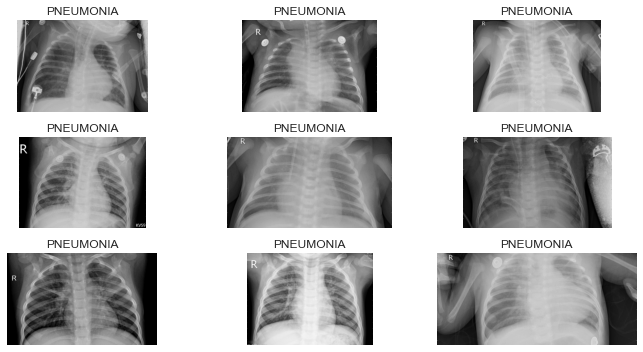

In [21]:
plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

### NORMAL X-ray images

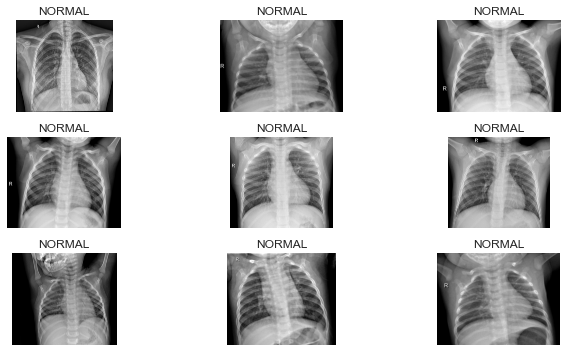

In [22]:

noraml = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, noraml[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()


In [41]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

print(len(pneumonia_train), len(normal_train))

3875 1341


In [42]:
# Creating DataFrame
# concatenate 함수는 numpy 배열들을 하나로 합치는데 사용

data = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

In [43]:
data.head()

,class
0,0
1,0
2,0
3,0
4,0


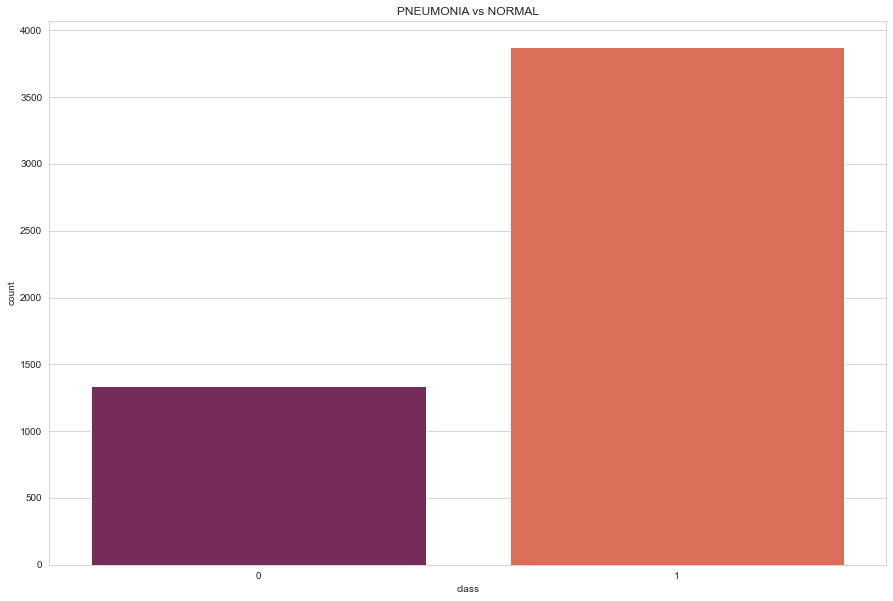

In [38]:
plt.figure(figsize=(15,10))
sns.countplot(data['class'],data=data,palette='rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

In [44]:
# 부족한 pneumonia 데이터셋을 ImageDatagenerator를 사용하여 더 만들어 준다.

img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [45]:
train = img_Datagen.flow_from_directory(train_dir, batch_size=32, class_mode='binary')
validation = val_Datagen.flow_from_directory(val_dir, batch_size=2, class_mode='binary')
test = val_Datagen.flow_from_directory(test_dir, batch_size=2, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [93]:
img, label = next(train)

(32, 256, 256, 3) [1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 1.]


# Defining the model
####  using the model 'VGG19', 'ResNet50v2', 'MObileNet50v2'

In [49]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation= 'relu')(x)

# output
predictions = tf.keras.layers.Dense(1, activation= 'sigmoid')(x)

model = tf.keras.Model(inputs = vgg_model.input, outputs= predictions)


# 오버핏팅을 피하기
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)

# learning_rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 8)

# compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-12 12:27:23.549856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-12 12:27:23.550897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


80134624/80134624 [==============================] - 2s 0us/step


In [50]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [51]:
# 학습
history = model.fit(train, epochs=30, validation_data=validation, steps_per_epoch=100, 
callbacks=[early_stopping, lr],
batch_size=32)


Epoch 1/30


2022-07-12 12:29:26.865330: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-12 12:29:27.172179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.4757 - accuracy: 0.7806

2022-07-12 12:30:55.216527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 89s 866ms/step - loss: 0.4757 - accuracy: 0.7806 - val_loss: 0.5056 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 85s 842ms/step - loss: 0.4257 - accuracy: 0.8109 - val_loss: 0.4985 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 85s 842ms/step - loss: 0.4010 - accuracy: 0.8212 - val_loss: 0.5672 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 85s 841ms/step - loss: 0.3807 - accuracy: 0.8272 - val_loss: 0.4425 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 85s 841ms/step - loss: 0.3516 - accuracy: 0.8434 - val_loss: 0.4806 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 85s 844ms/step - loss: 0.3284 - accuracy: 0.8525 - val_loss: 0.4223 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 85s 841ms

# Evaluating the VGG19

In [52]:
score = model.evaluate(train)

print("Train Loss; ", score[0])
print('Train Accuracy: ', score[1])

163/163 [==============================] - 143s 873ms/step - loss: 0.2409 - accuracy: 0.8959
Train Loss;  0.2409059852361679
Train Accuracy:  0.8958972692489624


In [53]:
# Test data

score = model.evaluate(test)

print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])

312/312 [==============================] - 19s 59ms/step - loss: 0.3222 - accuracy: 0.8846
Test Loss:  0.32224419713020325
Test Accuracy:  0.884615421295166


Text(0.5, 1.0, 'Accuracy Evaluation')

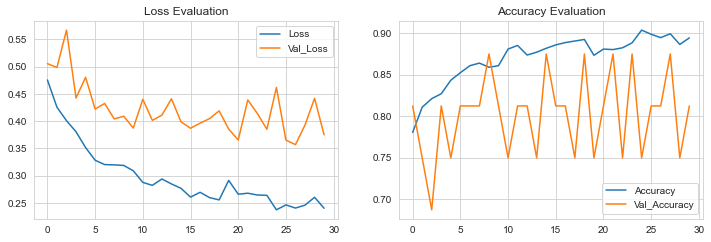

In [54]:
plt.figure(figsize=(12,8))
plt.title('Evaluation of VGG19')

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evaluation')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evaluation')



# ResNet50V2 모델 사용

In [58]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False

x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# output layer
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)


# overfitting을 피하기 위해 early_stopping 사용, 위에서 작성함
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)

# compile
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [59]:
# 모델 훈련
history = model2.fit(train, epochs=30, validation_data=validation, steps_per_epoch=100,
callbacks=[early_stopping, lr],
batch_size=32
)

Epoch 1/30


2022-07-12 13:31:55.130638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.8731

2022-07-12 13:32:46.085113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 53s 502ms/step - loss: 0.2841 - accuracy: 0.8731 - val_loss: 0.2991 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 51s 503ms/step - loss: 0.2084 - accuracy: 0.9134 - val_loss: 0.1452 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 50s 499ms/step - loss: 0.1863 - accuracy: 0.9234 - val_loss: 0.1301 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 49s 489ms/step - loss: 0.1864 - accuracy: 0.9200 - val_loss: 0.1909 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 48s 476ms/step - loss: 0.1716 - accuracy: 0.9325 - val_loss: 0.2436 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 49s 483ms/step - loss: 0.1790 - accuracy: 0.9269 - val_loss: 0.1518 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 48s 474ms

In [60]:
# triain data와 test data 모델 평가

score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 78s 475ms/step - loss: 0.1286 - accuracy: 0.9482
Train Loss:  0.128639355301857
Train Accuracy:  0.9482362270355225
312/312 [==============================] - 9s 28ms/step - loss: 0.1929 - accuracy: 0.9343

Test loss:  0.1928553730249405
Test Accuracy:  0.9342948794364929


Text(0.5, 1.0, 'Accuracy Evolution')

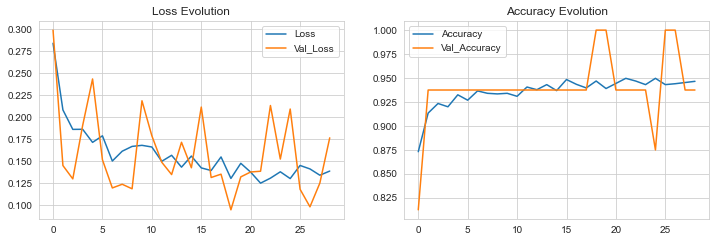

In [61]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

# MobileNetV2 모델 사용

In [65]:
mobilenet_model = tf.keras.applications.MobileNetV2(
    weights = 'imagenet', 
    include_top=False,
    input_shape = (224,224,3)
)

for layer in mobilenet_model.layers:
    layer.trainable=False

x = mobilenet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# output layer
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model3 = tf.keras.Model(inputs=mobilenet_model.input, outputs=predictions)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loass', patience=8)


# compile
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [66]:
history = model3.fit(train, epochs=30, validation_data=validation, steps_per_epoch=100, 
callbacks=[early_stopping], batch_size=32)

Epoch 1/30


2022-07-12 14:10:44.365546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.8603

2022-07-12 14:11:38.055570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 55s 529ms/step - loss: 0.3282 - accuracy: 0.8603 - val_loss: 0.4129 - val_accuracy: 0.8750
Epoch 2/30
100/100 [==============================] - 49s 478ms/step - loss: 0.2468 - accuracy: 0.8900 - val_loss: 0.1772 - val_accuracy: 0.9375
Epoch 3/30
100/100 [==============================] - 48s 477ms/step - loss: 0.2005 - accuracy: 0.9178 - val_loss: 0.3621 - val_accuracy: 0.8750
Epoch 4/30
100/100 [==============================] - 48s 475ms/step - loss: 0.1979 - accuracy: 0.9172 - val_loss: 0.3957 - val_accuracy: 0.8125
Epoch 5/30
100/100 [==============================] - 48s 474ms/step - loss: 0.2031 - accuracy: 0.9137 - val_loss: 0.5514 - val_accuracy: 0.8125
Epoch 6/30
100/100 [==============================] - 47s 464ms/step - loss: 0.1833 - accuracy: 0.9203 - val_loss: 0.3421 - val_accuracy: 0.8125
Epoch 7/30
100/100 [==============================] - 47s 464ms/step - loss: 0.1635 - accuracy: 0.9337 - val_loss: 0.2647 - val_accuracy: 0.9

In [67]:
# 모델 평가

score = model3.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model3.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 84s 505ms/step - loss: 0.1689 - accuracy: 0.9314
Train Loss:  0.16890539228916168
Train Accuracy:  0.9313650727272034
312/312 [==============================] - 6s 19ms/step - loss: 0.2891 - accuracy: 0.8798

Test loss:  0.2890627682209015
Test Accuracy:  0.879807710647583


2


Text(0.5, 1.0, 'Accuracy Evolution')

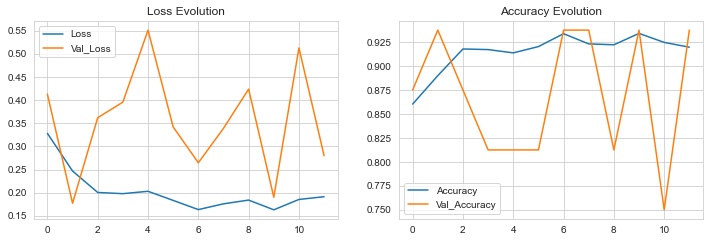

In [68]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

#### 모델 저장

In [69]:
model.save('vgg19.h5')
model2.save('resnet50v2.h5')
model3.save('mobilenetv2.h5')

### test data의 이미지를 가지고 예측해보기

2
1/1 [==============================] - 0s 12ms/step
[[0.37286195]]
This image is 62.71 percent NORMAL
This image is 37.29 percent PNEUMONIA


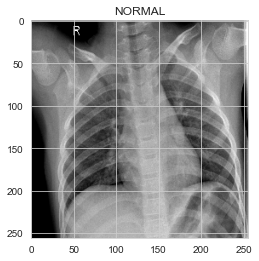

In [118]:
data, label = next(iter(test))
print(len(data))
image1 = data[0]
label_img = label[0]
class_name = ['NORMAL', 'PNEUMONIA']
plt.imshow(image1)
plt.title(class_name[int(label_img)])


prediction = model.predict(np.expand_dims(image1, 0))
print(prediction)

scores = [1- prediction, prediction]

for score, name in zip(scores, class_name):
    print("This image is %.2f percent %s" % ((100 * score), name))